<a href="https://colab.research.google.com/github/xiexukang/tensorflow-/blob/master/softmax%E5%9B%9E%E5%BD%92%E4%BB%8E%E9%9B%B6%E5%BC%80%E5%A7%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np

In [0]:
from tensorflow.keras.datasets import fashion_mnist
(train_x,train_y),(test_x,test_y) = fashion_mnist.load_data()

In [0]:
train_x,test_x = tf.cast(train_x,tf.float32)/255.0, tf.cast(test_x,tf.float32)/255.0

In [0]:
train_iter = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(256)
test_iter = tf.data.Dataset.from_tensor_slices((test_x,test_y)).batch(256)

In [0]:
num_inputs = 28*28
num_outputs =10
W = tf.Variable(tf.random.normal(shape=(num_inputs,num_outputs),mean=0,stddev=0.01,dtype=tf.float32))
b = tf.Variable(tf.zeros(num_outputs,dtype=tf.float32))

In [26]:
X = tf.constant([[1,2,3],[4,5,6]])
tf.reduce_sum(X,axis=0,keepdims=True),tf.reduce_sum(X,axis=1,keepdims=True)

(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[5, 7, 9]], dtype=int32)>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[ 6],
        [15]], dtype=int32)>)

In [0]:
def softmax(logits, axis =-1):
  return tf.exp(logits)/tf.reduce_sum(tf.exp(logits),axis,keepdims=True)

In [28]:
X = tf.random.normal(shape=(2,5))
X_prob = softmax(X)
X_prob,tf.reduce_sum(X_prob,axis=-1)

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.6332326 , 0.05690522, 0.13451333, 0.0781008 , 0.09724813],
        [0.08683766, 0.06681491, 0.21652348, 0.27806377, 0.35176012]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>)

In [29]:
X

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[ 2.0880232 , -0.32142746,  0.53884876, -0.0048143 ,  0.21445118],
       [-0.48713484, -0.7492489 ,  0.42652375,  0.67667526,  0.9117743 ]],
      dtype=float32)>

In [0]:
def net(X):
  logits = tf.matmul(tf.reshape(X,shape=(-1,W.shape[0])),W)+b
  return softmax(logits)

In [31]:
y_hat = np.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = np.array([0, 2], dtype='int32')
tf.boolean_mask(y_hat, tf.one_hot(y, depth=3))


<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.1, 0.5])>

In [32]:
help(tf.boolean_mask)

Help on function boolean_mask_v2 in module tensorflow.python.ops.array_ops:

boolean_mask_v2(tensor, mask, axis=None, name='boolean_mask')
    Apply boolean mask to tensor.
    
    Numpy equivalent is `tensor[mask]`.
    
    ```python
    # 1-D example
    tensor = [0, 1, 2, 3]
    mask = np.array([True, False, True, False])
    boolean_mask(tensor, mask)  # [0, 2]
    ```
    
    In general, `0 < dim(mask) = K <= dim(tensor)`, and `mask`'s shape must match
    the first K dimensions of `tensor`'s shape.  We then have:
      `boolean_mask(tensor, mask)[i, j1,...,jd] = tensor[i1,...,iK,j1,...,jd]`
    where `(i1,...,iK)` is the ith `True` entry of `mask` (row-major order).
    The `axis` could be used with `mask` to indicate the axis to mask from.
    In that case, `axis + dim(mask) <= dim(tensor)` and `mask`'s shape must match
    the first `axis + dim(mask)` dimensions of `tensor`'s shape.
    
    See also: `tf.ragged.boolean_mask`, which can be applied to both dense and
    ragge

In [0]:
def accuracy(y_hat, y):
    return np.mean((tf.argmax(y_hat, axis=1) == y))


In [34]:
accuracy(y_hat, y)

0.5

In [0]:
# 描述,对于tensorflow2中，比较的双方必须类型都是int型，所以要将输出和标签都转为int型
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for _, (X, y) in enumerate(data_iter):
        y = tf.cast(y,dtype=tf.int64)
        acc_sum += np.sum(tf.cast(tf.argmax(net(X), axis=1), dtype=tf.int64) == y)
        n += y.shape[0]
    return acc_sum / n


In [0]:
def cross_entropy(y_hat, y):
    y = tf.cast(tf.reshape(y, shape=[-1, 1]),dtype=tf.int32)
    y = tf.one_hot(y, depth=y_hat.shape[-1])
    y = tf.cast(tf.reshape(y, shape=[-1, y_hat.shape[-1]]),dtype=tf.int32)
    return -tf.math.log(tf.boolean_mask(y_hat, y)+1e-8)


In [0]:
batch_size =256

In [39]:
num_epochs, lr = 30, 0.1
# 本函数已保存在d2lzh包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X)
                l = tf.reduce_sum(loss(y_hat, y))
            grads = tape.gradient(l, params)
            if trainer is None:
                # 如果没有传入优化器，则使用原先编写的小批量随机梯度下降
                for i, param in enumerate(params):
                    param.assign_sub(lr * grads[i] / batch_size)
            else:
                # tf.keras.optimizers.SGD 直接使用是随机梯度下降 theta(t+1) = theta(t) - learning_rate * gradient
                # 这里使用批量梯度下降，需要对梯度除以 batch_size, 对应原书代码的 trainer.step(batch_size)
                trainer.apply_gradients(zip([grad / batch_size for grad in grads], params))  

            y = tf.cast(y, dtype=tf.float32)
            train_l_sum += l.numpy()
            train_acc_sum += tf.reduce_sum(tf.cast(tf.argmax(y_hat, axis=1) == tf.cast(y, dtype=tf.int64), dtype=tf.int64)).numpy()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'% (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

trainer = tf.keras.optimizers.SGD(lr)
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)


epoch 1, loss 0.4741, train acc 0.840, test acc 0.830
epoch 2, loss 0.4652, train acc 0.842, test acc 0.832
epoch 3, loss 0.4582, train acc 0.844, test acc 0.834
epoch 4, loss 0.4523, train acc 0.846, test acc 0.835
epoch 5, loss 0.4474, train acc 0.847, test acc 0.836
epoch 6, loss 0.4431, train acc 0.849, test acc 0.835
epoch 7, loss 0.4394, train acc 0.850, test acc 0.837
epoch 8, loss 0.4361, train acc 0.851, test acc 0.838
epoch 9, loss 0.4332, train acc 0.852, test acc 0.839
epoch 10, loss 0.4305, train acc 0.853, test acc 0.839
epoch 11, loss 0.4281, train acc 0.854, test acc 0.840
epoch 12, loss 0.4259, train acc 0.855, test acc 0.840
epoch 13, loss 0.4239, train acc 0.855, test acc 0.840
epoch 14, loss 0.4220, train acc 0.856, test acc 0.840
epoch 15, loss 0.4203, train acc 0.856, test acc 0.840
epoch 16, loss 0.4187, train acc 0.857, test acc 0.841
epoch 17, loss 0.4172, train acc 0.857, test acc 0.841
epoch 18, loss 0.4158, train acc 0.858, test acc 0.841
epoch 19, loss 0.41

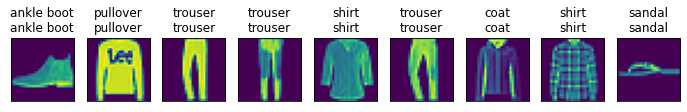

In [40]:
import matplotlib.pyplot as plt
X, y = iter(test_iter).next()

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_fashion_mnist(images, labels):
    # 这⾥的_表示我们忽略（不使⽤）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12)) # 这里注意subplot 和subplots 的区别
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(tf.reshape(img, shape=(28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(tf.argmax(net(X), axis=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_fashion_mnist(X[0:9], titles[0:9])


In [0]:
%matplotlib inline
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import random

def use_svg_display():
    # 用矢量图显示
    %config InlineBackend.figure_format = 'svg'

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

def xyplot(x_vals, y_vals, name):
    set_figsize(figsize=(5, 2.5))
    plt.plot(x_vals.numpy(), y_vals.numpy())
    plt.xlabel('x')
    plt.ylabel(name + '(x)')


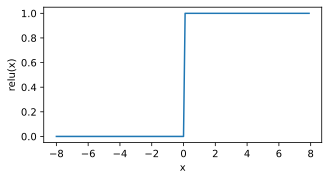

In [43]:
x = tf.Variable(tf.range(-8,8,0.1),dtype=tf.float32)


with tf.GradientTape() as tape:
  y = tf.nn.relu(x)
dydx=tape.gradient(y,x)

xyplot(x, dydx, 'relu')